## Architecture 1: MLP Model for Prediction ##

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pytorch_model_summary import summary

#progress bar
from tqdm.notebook import tqdm

#sklearn - useful utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:

# Load dataset
df = pd.read_csv(r"auxeticsdataset.csv")

# Display available columns
print("Available columns:", df.columns.tolist())

# Select valid features based on available columns
features = ['Slant cell length', 'Cell thickness', 'Cell angle', 'Vertical cell length']
target = "Poisson's ratio"

# Drop NaNs
df = df.dropna(subset=features + [target])

# Display dataset info
print("Dataset Shape:", df.shape)


Available columns: ['Slant cell length', 'Cell thickness', 'Cell angle', 'Vertical cell length', "Poisson's ratio"]
Dataset Shape: (8096, 5)


In [5]:
df.head()

,Slant cell length,Cell thickness,Cell angle,Vertical cell length,Poisson's ratio
0,4,2.0,70,25,0.058315
1,4,2.2,70,25,0.068378
2,4,2.4,70,25,0.076772
3,4,2.6,70,25,0.088180
4,4,2.8,70,25,0.101196


In [ ]:
#Split the dataset into training, validation, and testing data
#Picking a certain set of hyperparametes, we will train the model on the train data and evaluate using the val data for each epoch and total loss
#We will then, for the one with lowest loss, evaluate the model on the test data (which it has never seen before) and judge its performance

X_raw = df[features].values
y_raw = df[target].values

train_size = 0.7
val_size = 0.15
test_size = 0.15

#create a test set
X_train_temp_raw, X_test_raw, y_train_temp_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=test_size, random_state=42)

# create a validation set
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(X_train_temp_raw, y_train_temp_raw, test_size=val_size / (train_size + val_size), random_state=42)


C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\934177723.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(features, rotation=90)
C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\934177723.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(features, rotation=90)


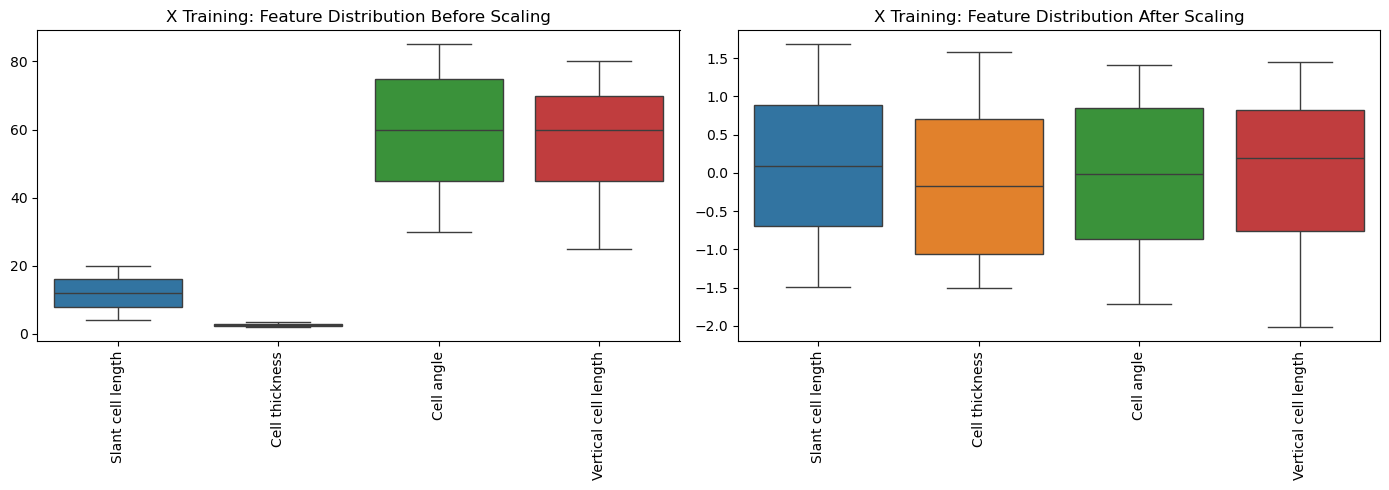

(5666, 4)

In [ ]:
#Scale the training x data- recommended for regression models with numerical values and plot it

# Apply StandardScaler
xscaler = StandardScaler()
X_train_scaled = xscaler.fit_transform(X_train_raw)

# Convert to DataFrame for easier plotting
df_raw = pd.DataFrame(X_train_raw, columns=features)
df_scaled = pd.DataFrame(X_train_scaled, columns=features)

# Plot before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before Scaling
sns.boxplot(data=df_raw, ax=axes[0])
axes[0].set_title("X Training: Feature Distribution Before Scaling")
axes[0].set_xticklabels(features, rotation=90)

# After Scaling
sns.boxplot(data=df_scaled, ax=axes[1])
axes[1].set_title("X Training: Feature Distribution After Scaling")
axes[1].set_xticklabels(features, rotation=90)

plt.tight_layout()
plt.show()

X_train_scaled.shape

C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\3697107316.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(features, rotation=90)
C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\3697107316.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(features, rotation=90)


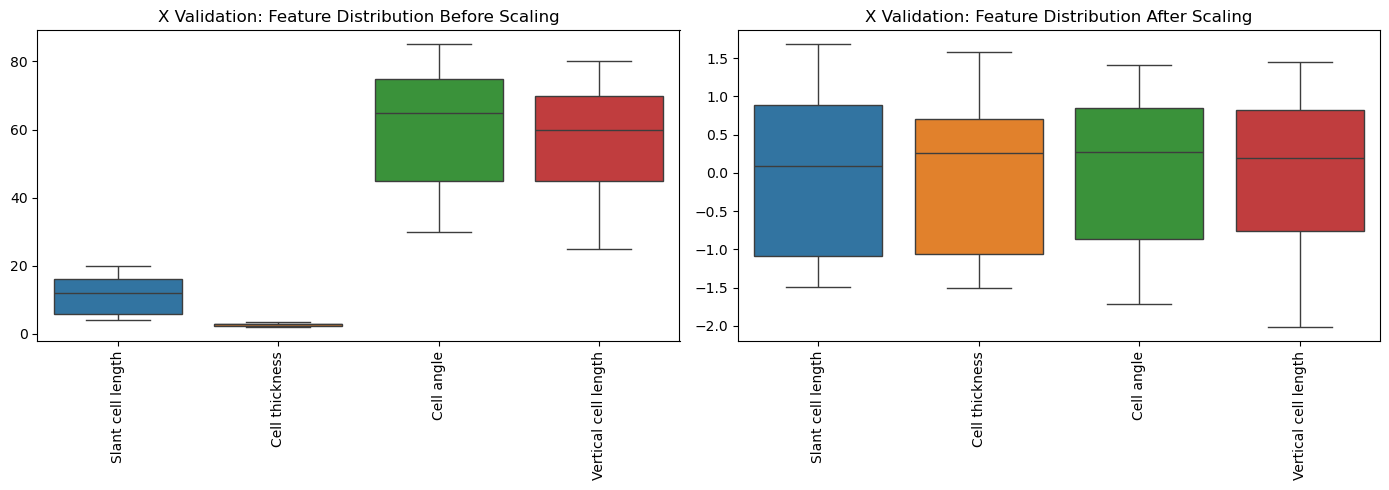

(1215, 4)

In [ ]:
#Scale the validation x data

# Apply StandardScaler
X_val_scaled = xscaler.transform(X_val_raw)

# Convert to DataFrame for easier plotting
df_raw = pd.DataFrame(X_val_raw, columns=features)
df_scaled = pd.DataFrame(X_val_scaled, columns=features)

# Plot before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before Scaling
sns.boxplot(data=df_raw, ax=axes[0])
axes[0].set_title("X Validation: Feature Distribution Before Scaling")
axes[0].set_xticklabels(features, rotation=90)

# After Scaling
sns.boxplot(data=df_scaled, ax=axes[1])
axes[1].set_title("X Validation: Feature Distribution After Scaling")
axes[1].set_xticklabels(features, rotation=90)

plt.tight_layout()
plt.show()

X_val_scaled.shape

C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\1819887403.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(features, rotation=90)
C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\1819887403.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(features, rotation=90)


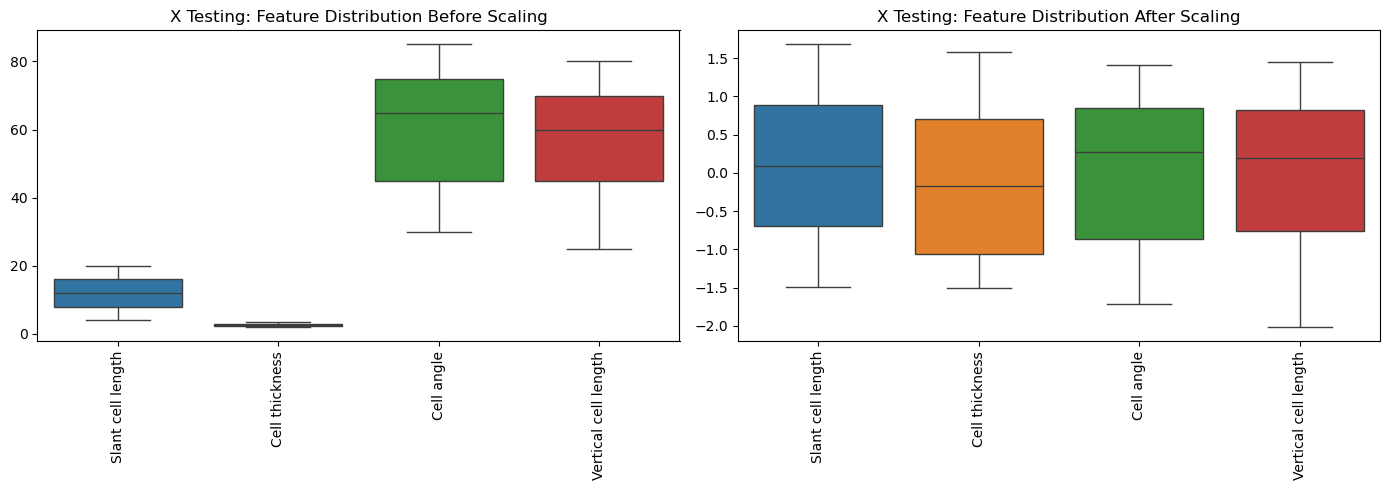

(1215, 4)

In [ ]:
#Scale the testing x data

# Apply StandardScaler
X_test_scaled = xscaler.transform(X_test_raw)

# Convert to DataFrame for easier plotting
df_raw = pd.DataFrame(X_test_raw, columns=features)
df_scaled = pd.DataFrame(X_test_scaled, columns=features)

# Plot before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before Scaling
sns.boxplot(data=df_raw, ax=axes[0])
axes[0].set_title("X Testing: Feature Distribution Before Scaling")
axes[0].set_xticklabels(features, rotation=90)

# After Scaling
sns.boxplot(data=df_scaled, ax=axes[1])
axes[1].set_title("X Testing: Feature Distribution After Scaling")
axes[1].set_xticklabels(features, rotation=90)

plt.tight_layout()
plt.show()

X_test_scaled.shape

C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\3958826413.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(features, rotation=90)
C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\3958826413.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(features, rotation=90)


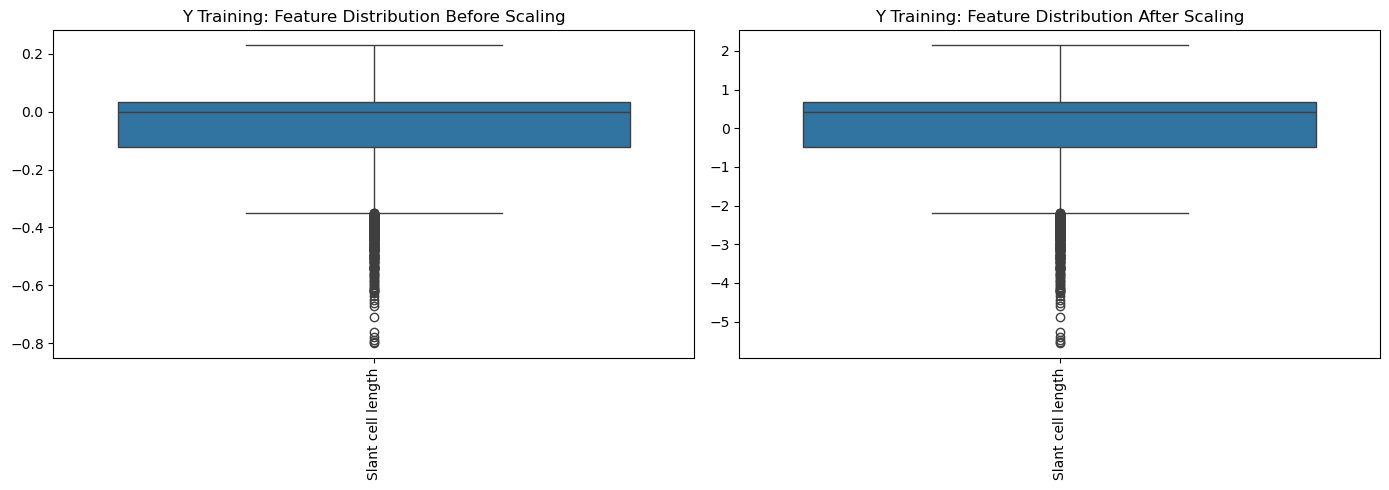

(5666, 1)

In [ ]:
#Scale the training y data

# Apply StandardScaler
yscaler = StandardScaler()
y_train_scaled = yscaler.fit_transform(y_train_raw.reshape(-1, 1))

# Convert to DataFrame for easier plotting
df_raw = pd.DataFrame(y_train_raw, columns=[target])
df_scaled = pd.DataFrame(y_train_scaled, columns=[target])

# Plot before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before Scaling
sns.boxplot(data=df_raw, ax=axes[0])
axes[0].set_title("Y Training: Feature Distribution Before Scaling")
axes[0].set_xticklabels(features, rotation=90)

# After Scaling
sns.boxplot(data=df_scaled, ax=axes[1])
axes[1].set_title("Y Training: Feature Distribution After Scaling")
axes[1].set_xticklabels(features, rotation=90)

plt.tight_layout()
plt.show()

y_train_scaled.shape

C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\2843926393.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(features, rotation=90)
C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\2843926393.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(features, rotation=90)


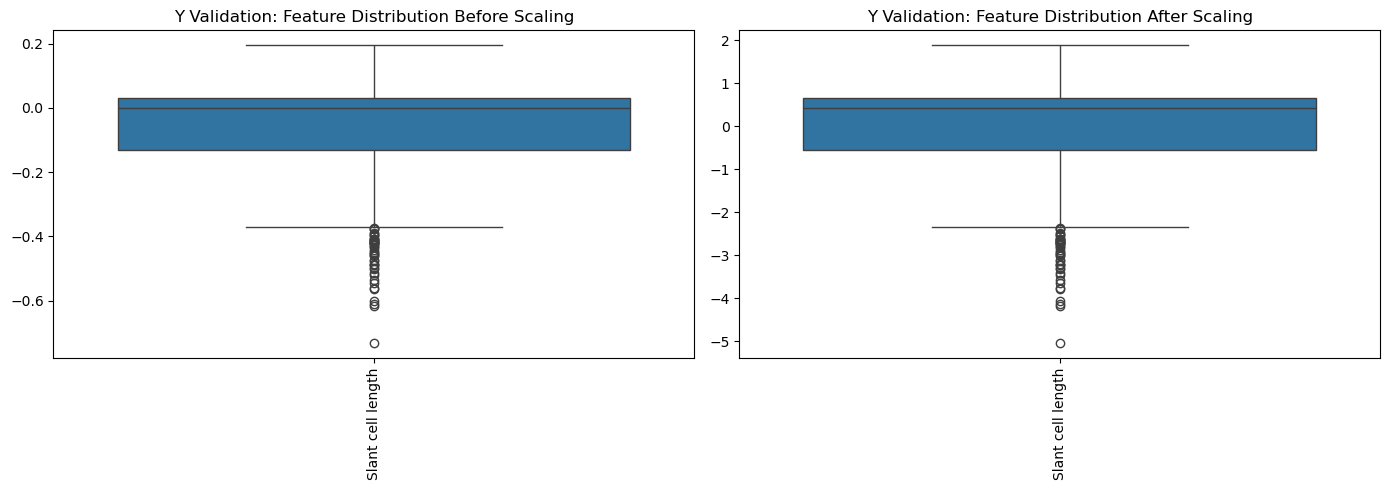

(1215, 1)

In [ ]:
#Scale the validation y data

# Apply StandardScaler
y_val_scaled = yscaler.transform(y_val_raw.reshape(-1,1))

# Convert to DataFrame for easier plotting
df_raw = pd.DataFrame(y_val_raw, columns=[target])
df_scaled = pd.DataFrame(y_val_scaled, columns=[target])

# Plot before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before Scaling
sns.boxplot(data=df_raw, ax=axes[0])
axes[0].set_title("Y Validation: Feature Distribution Before Scaling")
axes[0].set_xticklabels(features, rotation=90)

# After Scaling
sns.boxplot(data=df_scaled, ax=axes[1])
axes[1].set_title("Y Validation: Feature Distribution After Scaling")
axes[1].set_xticklabels(features, rotation=90)

plt.tight_layout()
plt.show()

y_val_scaled.shape

C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\2173581783.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(features, rotation=90)
C:\Users\kamak\AppData\Local\Temp\ipykernel_73156\2173581783.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(features, rotation=90)


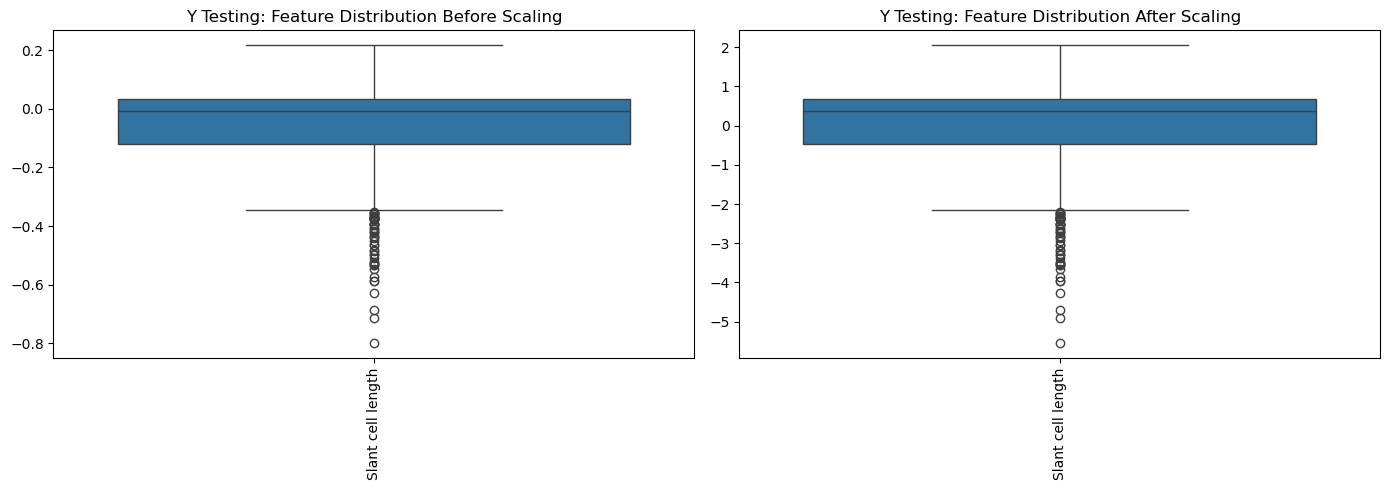

(1215, 1)

In [ ]:
#Scale the testing y data

# Apply StandardScaler
y_test_scaled = yscaler.transform(y_test_raw.reshape(-1,1))

# Convert to DataFrame for easier plotting
df_raw = pd.DataFrame(y_test_raw, columns=[target])
df_scaled = pd.DataFrame(y_test_scaled, columns=[target])

# Plot before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before Scaling
sns.boxplot(data=df_raw, ax=axes[0])
axes[0].set_title("Y Testing: Feature Distribution Before Scaling")
axes[0].set_xticklabels(features, rotation=90)

# After Scaling
sns.boxplot(data=df_scaled, ax=axes[1])
axes[1].set_title("Y Testing: Feature Distribution After Scaling")
axes[1].set_xticklabels(features, rotation=90)

plt.tight_layout()
plt.show()

y_test_scaled.shape

In [ ]:
#make a dataset class for the dataloader

class ReentrantDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ReentrantDataset(X_train_scaled, y_train_scaled)
val_dataset = ReentrantDataset(X_val_scaled, y_val_scaled)
test_dataset = ReentrantDataset(X_test_scaled, y_test_scaled)


In [ ]:
#create dataloaders

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
# Define MLP model
class PoissonPredictor(nn.Module):
    def __init__(self, input_size):
        super(PoissonPredictor, self).__init__()
        self.hidden1 = nn.Linear(input_size, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        x = self.output(x)
        return x

# Initialize model
model = PoissonPredictor(input_size=X_train_scaled.shape[1])
model.to(device)

print("\nNeural Network Architecture Summary:")
# input_size=(1, X_train.shape[1])
print(summary(model, torch.tensor(X_train_scaled, dtype=torch.float32), show_input=False))


Neural Network Architecture Summary:
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1          [5666, 64]             320             320
            ReLU-2          [5666, 64]               0               0
          Linear-3          [5666, 32]           2,080           2,080
            ReLU-4          [5666, 32]               0               0
          Linear-5          [5666, 16]             528             528
            ReLU-6          [5666, 16]               0               0
          Linear-7           [5666, 1]              17              17
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
-----------------------------------------------------------------------


Training Progress:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch [10/96], Train Loss: 0.0092, Val Loss: 0.0079
Epoch [20/96], Train Loss: 0.0040, Val Loss: 0.0041
Epoch [30/96], Train Loss: 0.0028, Val Loss: 0.0034
Epoch [40/96], Train Loss: 0.0022, Val Loss: 0.0033
Epoch [50/96], Train Loss: 0.0019, Val Loss: 0.0026
Epoch [60/96], Train Loss: 0.0016, Val Loss: 0.0025
Epoch [70/96], Train Loss: 0.0014, Val Loss: 0.0029
Epoch [80/96], Train Loss: 0.0016, Val Loss: 0.0021
Epoch [90/96], Train Loss: 0.0012, Val Loss: 0.0021


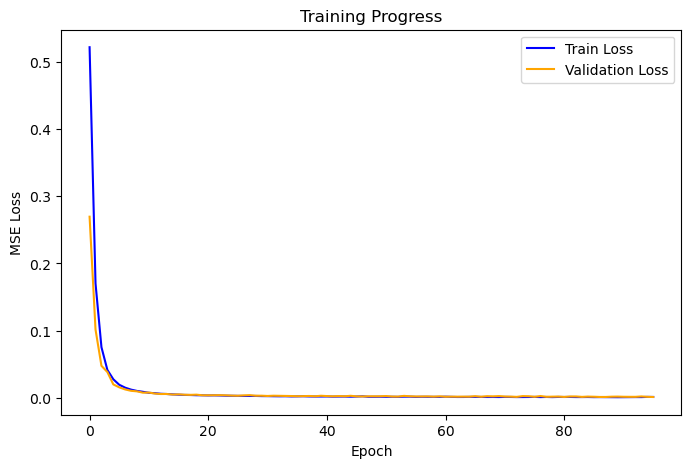

In [ ]:

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #try 0.01

# Training loop with tqdm progress bar
num_epochs = 96

train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    #Train on training set
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on validation set
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Progress")
plt.show()


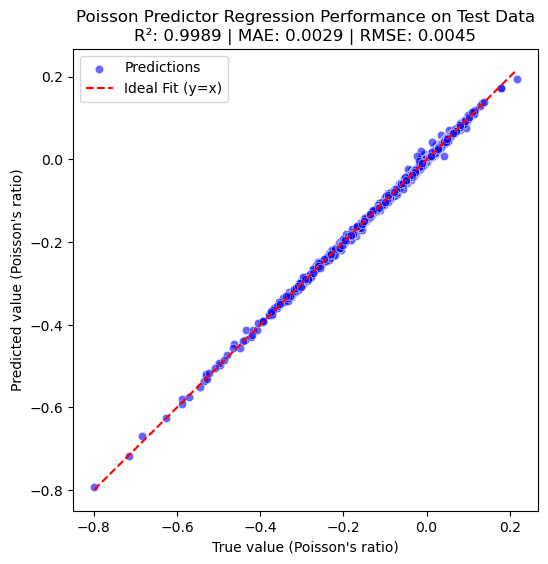

In [ ]:
# Evaluate the model on test dataset, which it has not seen before

model.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_pred = yscaler.inverse_transform(outputs.cpu().numpy())
        y_true = yscaler.inverse_transform(targets.cpu().numpy())
        y_pred_list.extend(y_pred)
        y_true_list.extend(y_true)

y_pred_arr = np.asarray(y_pred_list)
y_true_arr = np.asarray(y_true_list)

r2 = r2_score(y_true_arr, y_pred_arr)
mae = mean_absolute_error(y_true_arr, y_pred_arr)
rmse = np.sqrt(mean_squared_error(y_true_arr, y_pred_arr))

# Scatter plot with performance metrics
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true_arr.flatten(), y=y_pred_arr.flatten(), alpha=0.6, color="blue", label="Predictions")
plt.plot([y_true_arr.min(), y_true_arr.max()], [y_true_arr.min(), y_true_arr.max()], "--", color="red", label="Ideal Fit (y=x)")
plt.xlabel(f"True value ({target})")
plt.ylabel(f"Predicted value ({target})")
plt.title(f"Poisson Predictor Regression Performance on Test Data\nR²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
plt.legend()
plt.show()

#R² Score (r2_score): Measures how well predictions match actual values (1 = perfect, 0 = no relationship).
#Mean Absolute Error (MAE): Average absolute difference between predicted and true values.
#Root Mean Squared Error (RMSE): Measures error magnitude, giving more weight to large errors.


## Architecture 2: Symbolic Regression with PySR ##

In [ ]:
import sympy
import pysr
from pysr import PySRRegressor

C:\Users\kamak\anaconda3\envs\pytorch\lib\site-packages\juliacall\__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [ ]:
#Train the PySR model on the same training data that was used for the MLP model
#Train on scaled data so easier for model to find relationships

model_sr = PySRRegressor(
    populations=30,
    population_size=100,
    niterations=200,
    random_state=42,
    # procs=8,
    deterministic=True,
    parallelism='serial',
    binary_operators=['+', '-', '*', '/'],
    unary_operators=['sqrt'], #'square','sin','cos'
    parsimony=1e-4,
    maxsize=40,  # Slightly increased
    model_selection='accuracy',
    verbosity=False
)

print("\nStarting Symbolic Regression...")
variable_names = ['Slant_cell_length', 'Cell_thickness', 'Cell_angle', 'Vertical_cell_length']
model_sr.fit(X_train_scaled, y_train_scaled, variable_names=variable_names)


Starting Symbolic Regression...


C:\Users\kamak\anaconda3\envs\pytorch\lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                      -1.0133219e-5   
	1         0.290130                     Slant_cell_length / -1.5070021   
	2         0.003790       (Slant_cell_length - Cell_angle) * -0.487176   
	3         0.078625  (Slant_cell_length - (Cell_angle * 0.42841884)...   
	4         0.108524  (Cell_angle - Slant_cell_length) / ((Cell_angl...   
	5         0.096914  ((-1.1348819 - Slant_cell_length) / ((Cell_ang...   
	6         0.073983  (Cell_angle - Slant_cell_length) / ((Cell_angl...   
	7         0.363726  ((-1.3722492 - Slant_cell_length) / (((Cell_an...   
	8         0.064836  ((((Cell_angle * (Cell_angle - -0.77914834)) -...   
	9         0.035840  (((Cell_angle + -2.2677364) - Slant_cell_lengt...   
	10        0.068144  (((Slant_cell_length + 1.3434954) * ((Cell_ang...   
	11        0.005069  (((Slant_cell_length + 1.2221973) * ((sqrt(Cel...   
	12        0.271009  0.73864996 - (((3.0218859 / ((Cell_angle * Cel...   
	13        0.224788  0.7239316 - ((((Slant_cell_length + 1.7491125)...   
	14        0.179000  (((Cell_angle * 2.3011591) - (Slant_cell_lengt...   
	15        0.044487  (((((Cell_angle * 2.7811844) - (Slant_cell_len...   
	16        0.048205  ((((Slant_cell_length + 1.2594583) * ((((Cell_...   
	17        0.017368  (((((Slant_cell_length + 1.2327346) * ((-2.169...   
	18        0.057551  (((((Slant_cell_length + 1.2546033) * (((Slant...   
	19        0.011514  ((((((Slant_cell_length * -0.7782351) + ((Cell...   
	20        0.010867  (((((((Slant_cell_length * -0.78520936) + -2.1...   
	21  >>>>  0.041822  ((((((Slant_cell_length + 1.2025617) / ((Cell_...   
	
	        loss  complexity  
	0   1.000000           1  
	1   0.559753           3  
	2   0.555526           5  
	3   0.474692           7  
	4   0.382075           9  
	5   0.314753          11  
	6   0.292308          12  
	7   0.203178          13  
	8   0.178468          15  
	9   0.172185          16  
	10  0.160843          17  
	11  0.160029          18  
	12  0.122040          19  
	13  0.077849          21  
	14  0.054422          23  
	15  0.049789          25  
	16  0.045213          27  
	17  0.043670          29  
	18  0.038922          31  
	19  0.038036          33  
	20  0.037218          35  
	21  0.034231          37  
]

In [ ]:
#See what equation looks like
model_sr.sympy()

-1*(-0.51475453) + (((Cell_thickness + 0.18204705)*(-0.08151639) + (Slant_cell_length + 1.2025617)/(Cell_angle*(Cell_angle + Slant_cell_length*(-0.12640929)) + 0.67731667))*(Cell_angle*2.2364216 + Slant_cell_length*(-0.7241246) - 2.2334182) + 0.56697357)/(Vertical_cell_length + 3.1836758)

In [ ]:
variable_names = ['Slant_cell_length', 'Cell_thickness', 'Cell_angle', 'Vertical_cell_length']

#Function for parsing model output to a function in Python and plotting its performance on test data
def evaluate_pysr_sympy(sympy_expression, X_test, y_test, variable_names, scaler):
    """
    Evaluates the performance of a SymPy expression generated by PySR on test data.
    """
    f = None
    try:
        # 1. Convert the SymPy expression string to a SymPy expression object.
        x = [sympy.Symbol(name) for name in variable_names]
        expression = sympy.sympify(sympy_expression)

        # 2. Create a numerical function from the SymPy expression.
        f = sympy.lambdify(x, expression, modules="numpy")
        if not callable(f):
            print("Error: sympy.lambdify failed to create a callable function.")
            print(f"SymPy Expression: {sympy_expression}")
            return None

        if X_test.ndim == 1:
            y_pred = f(*X_test)
        else:
            X_test = np.array(X_test)
            try:
                y_pred = f(*X_test.T)
            except TypeError as e:
                print(f"X_test shape: {X_test.shape}")
                print(f"Number of variables: {len(variable_names)}")
                print(f"SymPy Expression: {sympy_expression}")
                if "takes" in str(e) and "positional arguments but" in str(e) and len(variable_names) == 4:
                    print("Potential issue: The lambdify function received too many arguments.  "
                          "Ensure that the number of columns in X_test matches the number of variables in the SymPy expression.")
                    return None
                else:
                    raise

        #Unscale the y data
        y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
        y_test = scaler.inverse_transform(y_test.reshape(-1,1))

        y_pred = np.array(y_pred).flatten()
        y_test = np.array(y_test).flatten()

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        #Scatterplot with performance metrics
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="blue", label="Predictions")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="red", label="Ideal Fit (y=x)")
        plt.xlabel(f"True value (Poisson's Ratio)")
        plt.ylabel(f"Predicted value (Poisson's Ratio)")
        plt.title(f"Symbolic Regression Equation Performance on Test Data\nR²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error during evaluation: {e}")
        return None


PySR's best SymPy equation: -1*(-0.51475453) + (((Cell_thickness + 0.18204705)*(-0.08151639) + (Slant_cell_length + 1.2025617)/(Cell_angle*(Cell_angle + Slant_cell_length*(-0.12640929)) + 0.67731667))*(Cell_angle*2.2364216 + Slant_cell_length*(-0.7241246) - 2.2334182) + 0.56697357)/(Vertical_cell_length + 3.1836758)


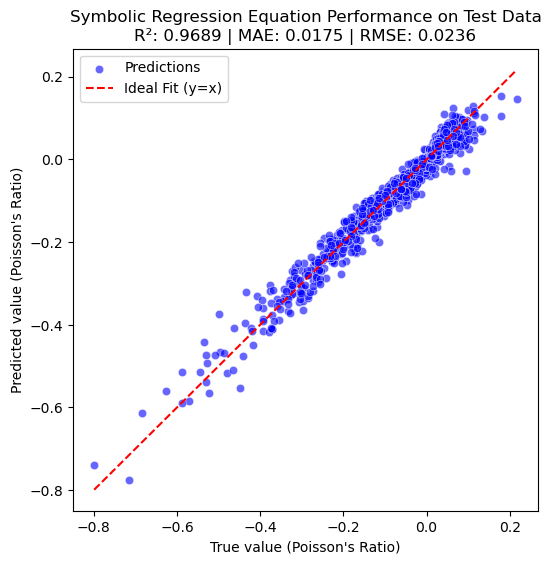

In [ ]:
#Evaluate the performance of the equation found by the model on the same test data as the MLP was evaluated on

best_equation_sympy = model_sr.sympy()
print(f"PySR's best SymPy equation: {best_equation_sympy}")

evaluate_pysr_sympy(best_equation_sympy, X_test_scaled, y_test_scaled, variable_names, yscaler)
